# Word Embedding Experiments with Wikipedia corpus

In [1]:
import numpy as np
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("WordCount")\
.config("spark.driver.maxResultSize", "3g").getOrCreate()

## Data Preparation

In [2]:
from collections import Counter
wiki_dir = '/project/cmsc25025/wikipedia/wiki-text.txt'
stopwords_dir = '/project/databases/nltk_data/corpora/stopwords/english'

#### Create vocab list by filtering out stop words and words appearing less than 500 times

In [3]:
wiki_file = open(wiki_dir,'r').readlines()[0]
stopwords = set((w.strip() for w in open(stopwords_dir)))  # stopwords from NLTK library

# using counter instead of parallelizing->filtering->collecting was faster by a minute
word_counts = Counter(wiki_file.split())
pmi_words = sorted(filter(lambda w: w not in stopwords and word_counts[w] >= 500, list(word_counts)))
vocab = set(pmi_words)
pmi_vocab = {w: idx for idx, w in enumerate(pmi_words)}
pmi_ivocab = {idx: w for idx, w in enumerate(pmi_words)}

#### Split data into chunks, [ $\mathrm{chunk}_1$, $\mathrm{chunk}_2$, ..., $\mathrm{chunk}_{700}$ ], where each $\mathrm{chunk}_i$ is a list of filtered strings in the order they appeared in the original wikipedia text

In [4]:
num_chunks = 1007  # make it a multiple of number of your cores
chunks, chunk_size = len(wiki_file), len(wiki_file)/num_chunks
wiki_chunks = [wiki_file[i:i+chunk_size] for i in range(0, chunks, chunk_size)]
wiki_data = spark.sparkContext.parallelize(wiki_chunks)\
.map(lambda x: x.split())\
.map(lambda words: filter(lambda w: w in vocab, words)).cache()

In [5]:
actual_num_chunks = wiki_data.count()
some_words = wiki_data.take(1)[0][:10]
print '%d chunks created' % actual_num_chunks
print 'First 10 words: %s, %s, %s, %s, %s, %s, %s, %s, %s, %s' % tuple(some_words)

1008 chunks created
First 10 words: anarchism, originated, term, abuse, first, used, early, working, class, radicals


## PMI Embeddings

IMPORTANT: We remove words from the data if they are not in the vocabulary *before* looking at context windows, so that the PMI embeddings are more reflective of nearby terms.

In [6]:
from scipy.sparse import coo_matrix, csr
import scipy
import cPickle as pickle

In [7]:
# chunk = [word1, word2, word3, ...]
def create_coocurrence(chunk):
    coocurrence = np.zeros((len(pmi_words), len(pmi_words)), dtype=np.uint16)
    n = len(chunk)
    for ind in xrange(5, n-5):
        i = pmi_vocab[chunk[ind]]
        for k in range(ind-5,ind)+range(ind+1,ind+6):  # 10-length window around the word
            j = pmi_vocab[chunk[k]]
            coocurrence[i,j] += 1 # update coocurrence matrix
    return coo_matrix(coocurrence)

The following code computing the PMI matrix $M$ is commented out because the final embedding vectors are serialized in pmi_embeddings.p

In [8]:
# coocurrences = wiki_data.map(lambda chunk: create_coocurrence(chunk)).reduce(lambda x, y: x+y)
# pickle.dump(coocurrences, open('coocurrence_matrix2.p','wb'))

In [9]:
# coocurrences = pickle.load(open('coocurrence_matrix2.p','rb'))

In [10]:
# D = np.sum(coocurrences>0)
# c = coocurrences.toarray().astype(float)
# M = np.log(((c+1)*D)/c.sum(axis=1,keepdims=True)/c.sum(axis=0,keepdims=True))

Compute the sparse SVD $M = U\Sigma V^\top = (U \Sigma^{1/2})(\Sigma^{1/2}V^\top)$ and set $W = U\Sigma^{1/2}$

In [11]:
# U, s, V = scipy.sparse.linalg.svds(scipy.sparse.csr_matrix(M), k=50)

In [12]:
# W = np.dot(U, np.diag(s))
# pickle.dump(W, open('pmi_embeddings.p','wb'))

In [13]:
W = pickle.load(open('pmi_embeddings.p','rb'))

## GloVe (https://nlp.stanford.edu/projects/glove/)

Used GloVe to generate embedding vectors, saved in wiki-vectors.txt and wiki-vocab.txt.

## Experiments

In [15]:
import re
import os

### Reading embeddings

In [16]:
pmi_matrix = W   # pmi embeddings
pmi_vectors = {}
for i, w in enumerate(pmi_words):
    pmi_vectors[w] = W[i]

In [17]:
vectors_file = 'wiki-vectors.txt'   # local embeddings
with open(vectors_file, 'r') as f:
    local_words = []
    local_vectors = {}
    local_matrix = []
    for line in f:
        vals = line.decode('utf-8').rstrip().split(' ')
        word, vector = vals[0], [float(x) for x in vals[1:]]
        local_words.append(word)
        local_vectors[word] = vector
        local_matrix.append(vector)
local_matrix = np.array(local_matrix)
local_ivocab = {idx: w for idx, w in enumerate(local_words)}

In [18]:
vectors_file = 'glove.6B.50d.txt'    # pretrained embeddings
with open(vectors_file, 'r') as f:
    pt_words = []
    pt_vectors = {}
    pt_matrix = []
    for line in f:
        vals = line.decode('utf-8').rstrip().split(' ')
        word, vector = vals[0], [float(x) for x in vals[1:]]
        pt_words.append(word)
        pt_vectors[word] = vector
        pt_matrix.append(vector)
pt_matrix = np.array(pt_matrix)
pt_ivocab = {idx: w for idx, w in enumerate(pt_words)}

### Finding the 5 closest words in each embedding space

Aside from Marx being the fifth closest word to Einstein, the results from all three embeddings are quite reasonable. It seems that the local and pretrained GloVe embeddings find words closer to the original word than the PMI embeddings (eg, "gop" vs "presidential" for republican); nonetheless, the words the PMI embedding finds for republican are political terms used in context surrounding republican.

It is unclear whether the local or pretrained GloVe embedding is "better" than the other -- each performs well on different words. For example, the pretrained embedding finds vague words like "science" and "biology" close to "physics" whereas the local embedding finds "theoretical" and "quantum." On the other hand, the pretrained embedding performs better on "algebra."

In [19]:
# given n-dim vector v and matrix with vectors in rows,
# returns the indices of the k closest vectors to v
def nearest_vectors_ind(v, emb_matrix, k):
    assert k >= 1
    distances = np.linalg.norm(v - emb_matrix, axis=1)
    if k == 1:
        return np.argmin(distances)
    else:
        return np.argsort(distances)[:k]


# given a word and embedding information, finds the k nearest
# words; returns a list
def nearest_words(w, emb_ivocab, emb_vectors, emb_matrix, k):
    v = np.array(emb_vectors[w])
    ind = nearest_vectors_ind(v, emb_matrix, k+1)
    return [emb_ivocab[i] for i in ind[1:]]

In [20]:
print '%-19s %-15d %-15d %-15d %-15d %-15d' % (' ', 1, 2, 3, 4, 5)
print ' '*18, '_'*80
for (i,w) in enumerate(['physics', 'republican', 'einstein', 'algebra', 'fish']):
    pmi_nearest5   = nearest_words(w, pmi_ivocab,   pmi_vectors,   pmi_matrix, 5)
    local_nearest5 = nearest_words(w, local_ivocab, local_vectors, local_matrix, 5)
    pt_nearest5    = nearest_words(w, pt_ivocab,    pt_vectors,    pt_matrix,    5)
    print '%-18s|' % ('\"' + w + '\"')
    print 'PMI embedding     | %-15s %-15s %-15s %-15s %-15s' % tuple(pmi_nearest5)
    print 'Local GloVe       | %-15s %-15s %-15s %-15s %-15s' % tuple(local_nearest5)
    print 'Pretrained GloVe  | %-15s %-15s %-15s %-15s %-15s' % tuple(pt_nearest5)
    if i != 4:
        print '%18s|' % ''
    else:
        print ''

                    1               2               3               4               5              
                   ________________________________________________________________________________
"physics"         |
PMI embedding     | mathematics     mathematical    quantum         sciences        analysis       
Local GloVe       | chemistry       mechanics       mathematics     theoretical     quantum        
Pretrained GloVe  | chemistry       mathematics     theoretical     science         biology        
                  |
"republican"      |
PMI embedding     | presidential    representative  senator         secretary       senate         
Local GloVe       | democrat        senator         representative  republicans     whig           
Pretrained GloVe  | gop             democrat        democratic      republicans     democrats      
                  |
"einstein"        |
PMI embedding     | relativity      mathematicians  astronomical    observer        marx           


### Solving a Sample Analogy

The "france: paris :: england : ?" analogy is solved using all three embeddings below. Only the local GloVe embeding correctly identifies London as the capital, however. The PMI's result is not entirely unexpected, since Wikipedia text may discuss education in Paris and Oxford more often than the political implications of London being the capital of England. It is unclear why Melbourne, a city in Australia, is the pretrained GloVe embedding's guess. 

In [30]:
# given words w1, w2, w3 creating an analogy of the form
# w1:w2=w3:?
# and word embedding information, finds the best best possible guess to complete the analogy
def solve_analogy(w1, w2, w3, emb_ivocab, emb_vectors, emb_matrix):
    try:
        v1, v2, v3 = emb_vectors[w1], emb_vectors[w2], emb_vectors[w3]
    except KeyError:
        return '[N/A]'
    v = np.array(v2) - v1 + v3
    ind = nearest_vectors_ind(v, emb_matrix, 4)
    words = set((w1, w2, w3))
    for i in (0,1,2,3):
        guess = emb_ivocab[ind[i]]
        if guess not in words:  # return a word different from the words passed in
            return guess

        
# solves an analogy using all three embeddings and prints the results
def print_solved_analogies(w1, w2, w3):
    pmi_sol   = solve_analogy(w1, w2, w3, pmi_ivocab,   pmi_vectors,   pmi_matrix)
    local_sol = solve_analogy(w1, w2, w3, local_ivocab, local_vectors, local_matrix)
    pt_sol    = solve_analogy(w1, w2, w3, pt_ivocab,    pt_vectors,    pt_matrix)
    print '                     %s : %s :: %s : ?' % (w1, w2, w3)
    print 'PMI embedding     |  %s' % pmi_sol
    print 'Local GloVe       |  %s' % local_sol
    print 'Pretrained GloVe  |  %s\n' % pt_sol

In [31]:
w1, w2, w3 = 'france', 'paris', 'england'
print_solved_analogies(w1, w2, w3)

                     france : paris :: england : ?
PMI embedding     |  oxford
Local GloVe       |  london
Pretrained GloVe  |  melbourne



### Solving Analogies Written by others

Performance across all analogies for each embedding varied immensely. For fact-based analogies (like japan:sushi::mexico=? and man:woman::mr:? and lincoln:republican::clinton:?), the pretrained embedding performs better, since the PMI embedding only looks for surrounding word-contexts. For context-based analogies, like fire:burning::ice:?, the PMI embedding performs better. Again, the performance of both GloVe embeddings varies, and it is difficult to tell when one will outperform the other.

Unfortunately, several of the analogies people have written are absolutely terrible (either too specific, too vague, out of order, or just out-right incorrect) so they offer no context to tell how one embedding performs better than the other (the local embedding solves "mathematics:gauss::physics:einstein" but the pretrained embedding solves "girlfriend:wife::boyfriend:husband," even though both are purely based on context).

Note that if any of the words are not found in the embedding, '[N/A]' is printed

In [32]:
analogies_dir = '/project/cmsc25025/assn4_analogy'
for filename in os.listdir(analogies_dir):
    if filename.endswith(".txt"):
        with open(os.path.join(analogies_dir, filename), 'r') as f:
            print 'Analogies in %s' % filename
            print '_'*65
            for analogy in f:
                try:
                    w1, w2, w3 = filter(None, re.split("[:=?\n]+", analogy))[:3]
                    print_solved_analogies(w1, w2, w3)
                except:
                    print 'Analogy not formatted correctly'          
        print ''

Analogies in jihongsong-zlin7.txt
_________________________________________________________________
                     segregate : unify :: damage : ?
PMI embedding     |  [N/A]
Local GloVe       |  [N/A]
Pretrained GloVe  |  overcome

                     argentina : brazil :: iran : ?
PMI embedding     |  korea
Local GloVe       |  pakistan
Pretrained GloVe  |  tehran

                     ashes : urn :: money : ?
PMI embedding     |  [N/A]
Local GloVe       |  cash
Pretrained GloVe  |  cash

                     telephone : cord :: television : ?
PMI embedding     |  appearances
Local GloVe       |  starred
Pretrained GloVe  |  spinal

                     walk : roam :: speak : ?
PMI embedding     |  [N/A]
Local GloVe       |  pakistanis
Pretrained GloVe  |  outsiders

                     novel : epilogue :: meal : ?
PMI embedding     |  [N/A]
Local GloVe       |  meals
Pretrained GloVe  |  multicourse

                     chinese : china :: french : ?
PMI embedding     |  fran

### t-SNE dimensionality reduction

The t-SNE algorithm projects high-dimensional data onto $\mathbb{R}^2$ in a way such that two points close to each other in the higher dimension are close to each other in the lower dimension. This gives a visual representation of words close to one another in context. We have found a clustering of financial terms, which have several smaller subclusters consisting of terms used together frequently. For example, "gain," "profit," "earnings," "analysts," and "expectations" are usually said in one breath when discussing quarterly company profits. This cluster is close to the cluster containing "investors," "markets," and "sales," since these are terms highly related to one another but also related to "earnings" and "expectations." 

If the frozen plot is not showing, we have put a screenshot of the plot thereafter.

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib notebook

<IPython.core.display.Javascript object>


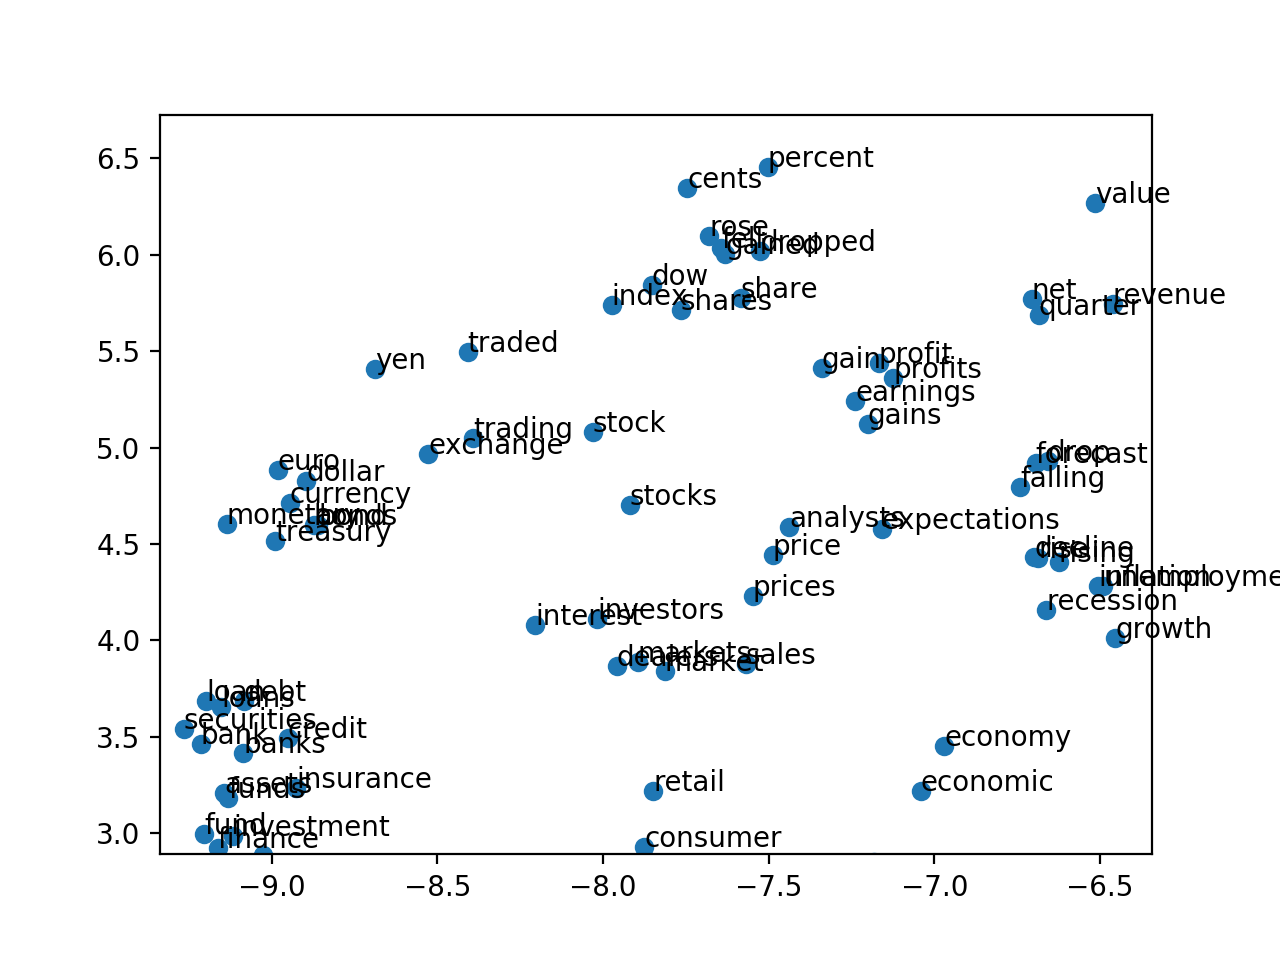

In [34]:
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(pt_matrix[:3000,:])
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(pt_words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

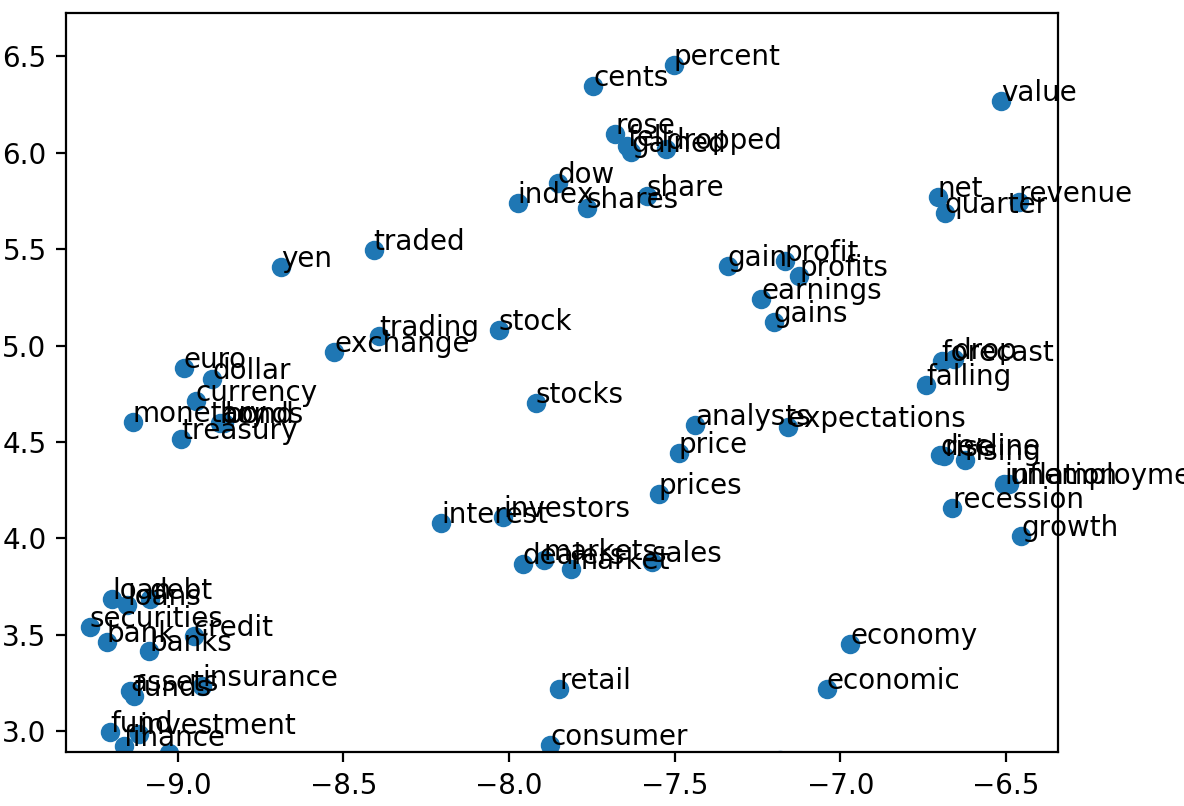

In [40]:
Image(filename='nakrishna-kevintse_tsne_prob2.png', width=600, height=600)